In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.signal
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
f_up = 2400.3e6
f_down = 10489.8e6
f_LO = f_down - f_up

In [3]:
obs_rate = 100

def load_file(filename):
    phase = np.fromfile(filename, dtype = 'float32').reshape((-1,2)).astype('double')
    start = np.datetime64(filename.strip('.f32x2').split('_')[-1])
    timestamps = start + np.timedelta64(1, 'ns') * np.arange(phase.shape[0]) * 1e9 / obs_rate
    for j in range(phase.shape[1]):
        phase[:,j] = np.unwrap(phase[:,j])
    return xr.Dataset({'phase' : (('time', 'signal'), phase)}, coords = {'time' : timestamps, 'signal' : ['bpsk', 'cw']})

In [4]:
obs1 = load_file('phase_2019-11-22T15:16:10.149971.f32x2').sel(time = slice('2019-11-22T15:17:00', '2019-11-22T15:31:00'))
obs2 = load_file('phase_2019-11-22T22:07:02.982902.f32x2').sel(time = slice('2019-11-22T22:08:00', '2019-11-22T22:43:00'))
obs3 = load_file('phase_2019-11-23T17:09:32.780821.f32x2').sel(time = slice('2019-11-23T17:10:00', '2019-11-23T17:55:00'))

/usr/lib64/python3.6/site-packages/IPython/core/pylabtools.py:124: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


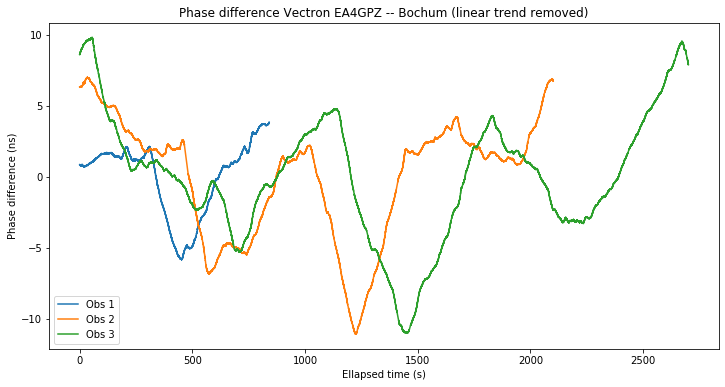

In [5]:
def plot_detrend(data):
    plt.plot((data.coords['time']-data.coords['time'][0]).astype('float')*1e-9,
         (scipy.signal.detrend((data['phase'].sel(signal = 'cw') - data['phase'].sel(signal = 'bpsk'))))*1e9/(2*np.pi*f_up))

plt.figure(figsize = (12,6), facecolor = 'w')
plot_detrend(obs1)
plot_detrend(obs2)
plot_detrend(obs3)
plt.title('Phase difference Vectron EA4GPZ -- Bochum (linear trend removed)')
plt.ylabel('Phase difference (ns)')
plt.xlabel('Ellapsed time (s)')
plt.legend(['Obs 1', 'Obs 2', 'Obs 3']);

In [6]:
def adev(series, skip, freq = 10e9, overlapping = False):
    x = series.values/(2*np.pi*freq)
    
    tau = skip / obs_rate
    if overlapping:
        y = x[:-2*skip] - 2*x[skip:-skip] + x[2*skip:]
    else:
        z = x[:x.size//skip*skip].reshape((-1,skip))[:,0]
        y = z[:-2] - 2*z[1:-1] + z[2:]
    return np.sqrt(0.5/tau**2*np.average(y**2))

def get_skips(n):
    if n <= 0:
        return np.array([], dtype = 'int')
    a = int(np.log10(n))
    step = max(10**(a-2), 1)
    return np.concatenate((get_skips(10**a - 1) , np.arange(10**a, n+1, step)))

def adevs(data, overlapping = False):
    skips = get_skips(data.coords['time'].size//2)
    taus = skips / obs_rate
    adevs_diff = [adev(data.sel(signal = 'cw')['phase'] - data.sel(signal = 'bpsk')['phase'], skip, f_up, overlapping) for skip in skips]
    adevs_bpsk = [adev(data.sel(signal = 'bpsk')['phase'], skip, f_down, overlapping) for skip in skips]
    adevs_cw = [adev(data.sel(signal = 'cw')['phase'], skip, f_LO, overlapping) for skip in skips]
    return xr.Dataset({'CW-BPSK' : ('tau', adevs_diff), 'BPSK' : ('tau', adevs_bpsk), 'CW' : ('tau', adevs_cw)},\
                     coords = {'tau' : taus})

In [7]:
adevs1 = adevs(obs1, overlapping = True)
adevs2 = adevs(obs2, overlapping = True)
adevs3 = adevs(obs3, overlapping = True)

In [8]:
obs_bpsk = xr.open_dataset('adevs_qo100_vectron.nc')

In [9]:
def plot_adevs(adevs, label, style):
    taus = adevs.coords['tau']
    plt.loglog(taus, adevs['CW-BPSK'], label = f'{label} CW-BPSK (2.4GHz)', color = 'C0', linestyle = style)
    plt.loglog(taus, adevs['BPSK'], label = f'{label} BPSK (10.5GHz)', color = 'C1', linestyle = style)
    plt.loglog(taus, adevs['CW'], label = f'{label} CW (8.1GHz)', color = 'C2', linestyle = style)

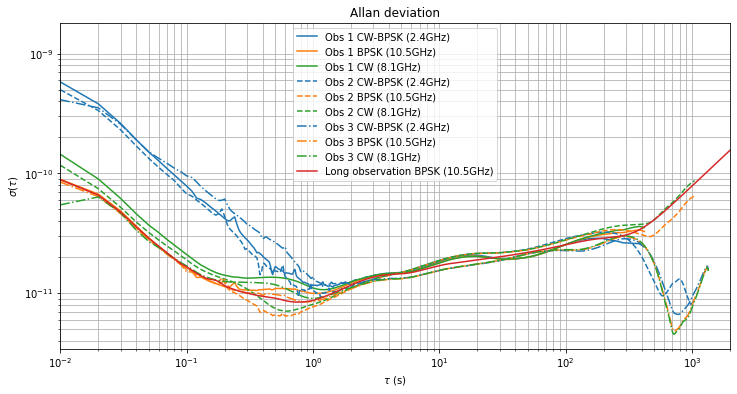

In [10]:
plt.figure(figsize = (12,6), facecolor = 'w')
plot_adevs(adevs1, 'Obs 1', '-')
plot_adevs(adevs2, 'Obs 2', '--')
plot_adevs(adevs3, 'Obs 3', '-.')
plt.loglog(obs_bpsk.coords['tau'], obs_bpsk['adev'], label = 'Long observation BPSK (10.5GHz)', color = 'C3')
plt.xlabel('$\\tau$ (s)')
plt.ylabel('$\\sigma(\\tau)$')
plt.legend()
plt.grid(which = 'both')
plt.title('Allan deviation')
plt.xlim([10**(-2), 2*10**3]);

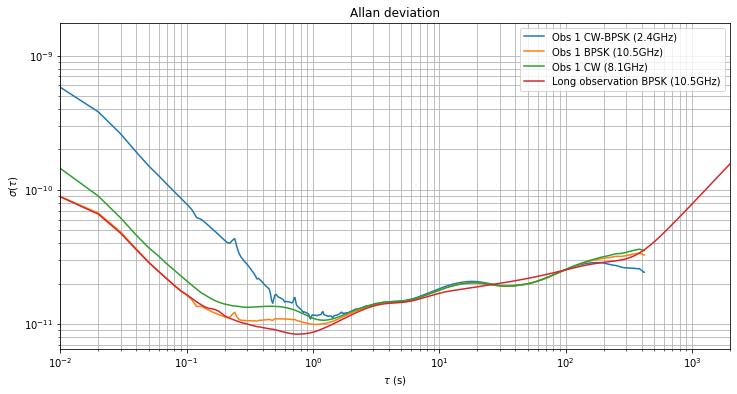

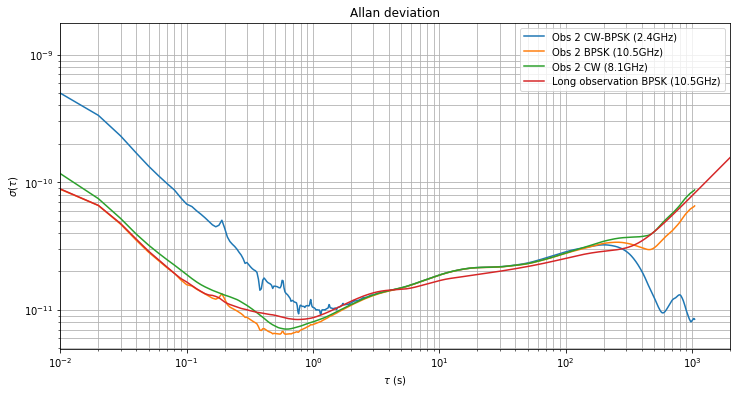

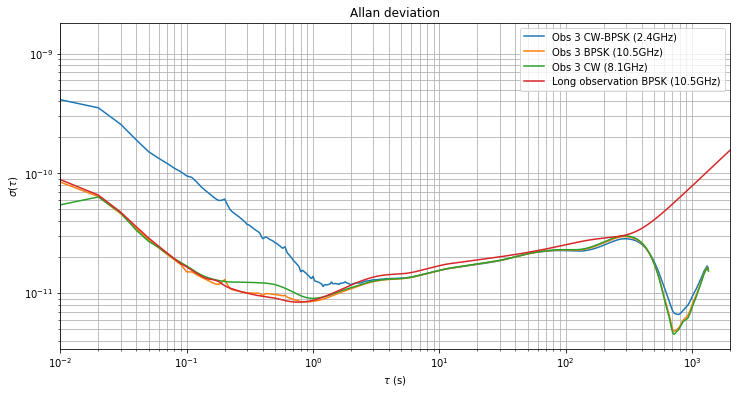

In [11]:
for n, devs in zip(range(1,4), [adevs1, adevs2, adevs3]):
    plt.figure(figsize = (12,6), facecolor = 'w')
    plot_adevs(devs, f'Obs {n}', '-')
    plt.loglog(obs_bpsk.coords['tau'], obs_bpsk['adev'], label = 'Long observation BPSK (10.5GHz)', color = 'C3')
    plt.xlabel('$\\tau$ (s)')
    plt.ylabel('$\\sigma(\\tau)$')
    plt.legend()
    plt.grid(which = 'both')
    plt.title('Allan deviation')
    plt.xlim([10**(-2), 2*10**3]);

In [12]:
def remove_quadratic(data):
    t = (data.coords['time']-data.coords['time'][0]).astype('float')*1e-9
    pf = np.polyfit(t, data['phase'], 2).T
    return xr.Dataset({'phase' : data['phase'] -np.array([np.polyval(p, t) for p in pf]).T},
                      coords = data.coords), pf

In [13]:
obs1_removed, pol1 = remove_quadratic(obs1)
obs2_removed, pol2 = remove_quadratic(obs2)
obs3_removed, pol3 = remove_quadratic(obs3)

In [14]:
for pol in [pol1, pol2, pol3]:
    print((pol[:,0] @ np.array([[-1,1,0],[1,0,1]])) / (2*np.pi*np.array([f_up, f_down, f_LO])))

[ 3.43410116e-14 -4.95695803e-14 -5.40881703e-14]
[8.95878169e-15 4.11504857e-14 5.60188057e-14]
[ 4.88935049e-15 -4.62035194e-15 -4.54053524e-15]


In [15]:
adevs1_removed = adevs(obs1_removed, overlapping = True)
adevs2_removed = adevs(obs2_removed, overlapping = True)
adevs3_removed = adevs(obs3_removed, overlapping = True)

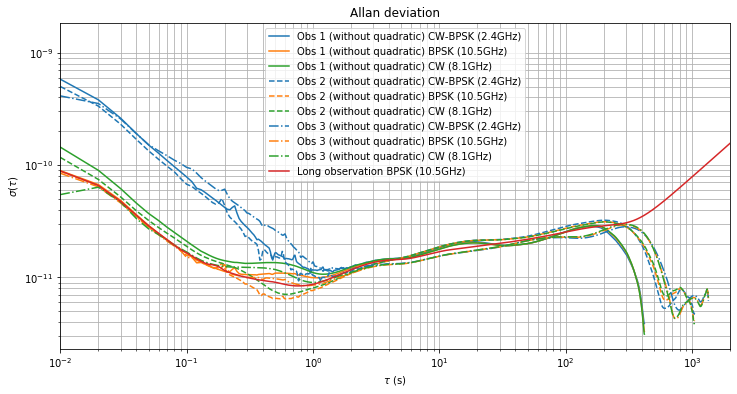

In [16]:
plt.figure(figsize = (12,6), facecolor = 'w')
plot_adevs(adevs1_removed, 'Obs 1 (without quadratic)', '-')
plot_adevs(adevs2_removed, 'Obs 2 (without quadratic)', '--')
plot_adevs(adevs3_removed, 'Obs 3 (without quadratic)', '-.')
plt.loglog(obs_bpsk.coords['tau'], obs_bpsk['adev'], label = 'Long observation BPSK (10.5GHz)', color = 'C3')
plt.xlabel('$\\tau$ (s)')
plt.ylabel('$\\sigma(\\tau)$')
plt.legend()
plt.grid(which = 'both')
plt.title('Allan deviation')
plt.xlim([10**(-2), 2*10**3]);